# Predict factor scores

Here we identify a subset of items that can be used to predict the true factor scores.

To do this we use the [FACSIMILE](https://github.com/tobywise/FACSIMILE) package.

First, import the necessary packages:

In [8]:
from facsimile.plotting import plot_predictions
from facsimile.eval import FACSIMILEOptimiser
from facsimile.utils import train_validation_test_split
import pandas as pd
import colormaps as cmaps
import sys
import os
sys.path.append('../../code')
from style import set_style
set_style('../../style.mplstyle')
import matplotlib.pyplot as plt

Font Heebo already available in Matplotlib.
Matplotlib style set to: ../../style.mplstyle with font Heebo


## Data

Next, we load the data. The `OCI_16` item is dropped as it is deemed too culturally-specific.

In [9]:
items = pd.read_csv("../../data/items.csv")
factor_scores = pd.read_csv("../../data/factor_scores.csv")

# Drop OCI_16 column
items = items.drop(columns='OCI_16')

It is important to split the data into three sets: training, validation, and test. The training set is used to fit the model, the validation set is used to select the best hyperparameter values, and the test set is used to evaluate the optimised model's performance. We can do this using the provided `train_validate_test_split` utility function.

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    items.iloc[:, 2:],  # Drop the first two columns, which are just IDs
    factor_scores.iloc[:, 2:],  # Drop the first two columns, which are just IDs
    train_size=0.6,
    test_size=0.2,
    val_size=0.2,
)

## Run the optimiser

The `FACSIMILEOptimiser` class runs a random search across the hyperparameter space to find regalularisation hyperparameter values that provide the best performance on the validation set. 


In [11]:
# Initialise the optimiser
optimiser = FACSIMILEOptimiser(n_iter=5000, n_jobs=10)

# Fit
optimiser.fit(X_train, y_train, X_val, y_val, factor_names=["AD", "Compul", "SW"])

Evaluation:   0%|          | 0/5000 [00:00<?, ?it/s]

Evaluation: 100%|██████████| 5000/5000 [02:48<00:00, 29.59it/s]


### View the results

The optimiser stores the results of each iteration in a pandas DataFrame. We can view the results using the `results_` attribute.

This contains columns representing the $R^2$ score for each factor on the validation set, the minimum $R^2$ score across all factors, and the hyperparameter values used for each iteration. We also get the number of items retained on each iteration, along with a `score` variable that balances the number of items retained with the minimum $R^2$ score according to the following formula:


$$\text{score} = \min(R^2) \cdot \left(1 - \frac{n_{included}}{n_{total}}\right)$$

Where $n_{included}$ is the number of items included, and $n_{total}$ is the total number of items.


In [12]:
optimiser.results_.head()

,run,r2_AD,r2_Compul,r2_SW,min_r2,scores,n_items,alpha_AD,alpha_Compul,alpha_SW
0,0,0.918298,0.941469,0.990727,0.918298,0.648990,61,0.648454,0.088522,0.050141
1,1,0.943385,0.797884,0.982315,0.797884,0.644444,40,0.281767,0.451665,0.067217
2,2,0.921996,0.754960,0.970634,0.754960,0.631553,34,0.422915,0.377139,0.120488
3,3,0.960795,0.943496,0.984583,0.943496,0.653189,64,0.263594,0.084933,0.173436
4,4,0.943833,0.838659,0.972880,0.838659,0.669315,42,0.267312,0.321228,0.095243


### Plot the results

We can also plot the results using the `plot_results` method. This plots the $R^2$ score for each factor on the validation set, along with the minimum $R^2$ score across all factors, and the number of items included on each iteration.

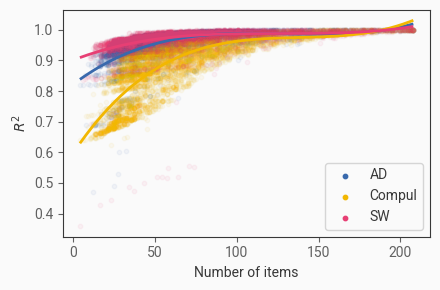

<Figure size 512x384 with 0 Axes>

In [13]:
optimiser.plot_results(cmap=cmaps.bold[2:5], figsize=(4.5, 3), scatter_kws={"s": 10, 'alpha': 0.05}, figure_kws={"dpi": 100})

# Save the figure
plt.savefig("../../figures/facsimile_optimisation.svg", bbox_inches='tight', dpi=300)

### Get the best classifier

We can get the best classifier from the optimiser using the `get_best_classifier` method. This returns a `FACSIMILEClassifier` object which can be used to predict factor scores for new participants.

The classifier is returned unfitted (i.e., just initialised with the best alpha values), so we then need to call the `fit` method to fit the classifier to the training data.

In [14]:
# Get the best classifier
best_clf = optimiser.get_best_classifier()

# Fit
best_clf.fit(X_train, y_train)

# Print number of included items
print("Number of included items: {}".format(best_clf.included_items.sum()))

# Save the weights
if not os.path.exists("../../models"):
    os.makedirs("../../models")
best_clf.get_weights().to_csv("../../models/weights_best.csv", index=False)

# Save the model
best_clf.save("../../models/best_model.pkl")

Number of included items: 29


We can then predict factor scores for the test data using the `predict` method and plot the predicted scores against the true scores.

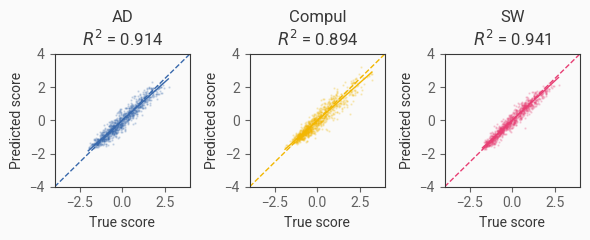

In [27]:
# Get predictions
y_pred = best_clf.predict(X_test)

# Plot
plot_predictions(
    y_test,
    y_pred,
    ["AD", "Compul", "SW"],
    palette=cmaps.bold[2:5]._colors,
    figure_kws={"figsize": (6, 2.5), "dpi": 100},
)

In [30]:
# get r2s
from sklearn.metrics import r2_score
r2s = r2_score(y_test, y_pred, multioutput='raw_values')

In [31]:
r2s

array([0.91398187, 0.8939812 , 0.9411595 ])

### Get the best classifier with <= 70 items

In our previous work we've aimed for around 70 items. We can use this criterion here, selecting the classifier with the best score that includes less than 70 items. 

In [16]:
# Get the best classifier
best_clf_70 = optimiser.get_best_classifier_max_items(70)

# Fit
best_clf_70.fit(X_train, y_train)

# Print number of included items
print("Number of included items: {}".format(best_clf_70.included_items.sum()))

# Save the weights
best_clf.get_weights().to_csv("../../models/weights_70item.csv", index=False)

# Save the model
best_clf.save("../../models/70item_model.pkl")

Number of included items: 70


Again, we can plot the predicted scores against the true scores.

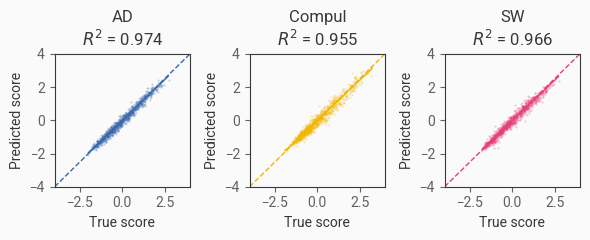

<Figure size 512x384 with 0 Axes>

In [17]:
# Get predictions
y_pred_70 = best_clf_70.predict(X_test)

# Plot
plot_predictions(
    y_test,
    y_pred_70,
    ["AD", "Compul", "SW"],
    palette=cmaps.bold[2:5]._colors,
    figure_kws={"figsize": (6, 2.5), "dpi": 100},
)

# Save the figure
plt.savefig("../../figures/facsimile_accuracy.svg", bbox_inches='tight', dpi=300)

## Predict for all subjects

In [18]:
# Best model
y_pred = best_clf.predict(items.iloc[:, 2:])
# Add ID and study columns
y_pred = pd.concat([items.iloc[:, :2], y_pred], axis=1)
# Save
y_pred.to_csv("../../data/predictions_best.csv", index=False)

# 70 item model
y_pred_70 = best_clf_70.predict(items.iloc[:, 2:])
# Add ID and study columns
y_pred_70 = pd.concat([items.iloc[:, :2], y_pred_70], axis=1)
# Save
y_pred_70.to_csv("../../data/predictions_70item.csv", index=False)

In [23]:
optimiser.results_

,run,r2_AD,r2_Compul,r2_SW,min_r2,scores,n_items,alpha_AD,alpha_Compul,alpha_SW
0,0,0.918298,0.941469,0.990727,0.918298,0.648990,61,0.648454,0.088522,0.050141
1,1,0.943385,0.797884,0.982315,0.797884,0.644444,40,0.281767,0.451665,0.067217
2,2,0.921996,0.754960,0.970634,0.754960,0.631553,34,0.422915,0.377139,0.120488
3,3,0.960795,0.943496,0.984583,0.943496,0.653189,64,0.263594,0.084933,0.173436
4,4,0.943833,0.838659,0.972880,0.838659,0.669315,42,0.267312,0.321228,0.095243
...,...,...,...,...,...,...,...,...,...,...
4995,4995,0.912294,0.914063,0.998437,0.912294,0.565798,79,0.758283,0.385957,0.009018
4996,4996,0.922947,0.691921,0.965987,0.691921,0.588798,31,0.353891,0.503692,0.158652
4997,4997,0.939040,0.984302,0.981386,0.939040,0.528210,91,0.601512,0.030305,0.280607
4998,4998,0.883406,0.664703,0.949702,0.664703,0.613572,16,0.574111,0.502975,0.342253


In [22]:
dir(best_clf_70)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_validate_params',
 'alphas',
 'clf',
 'factor_names',
 'fit',
 'fit_intercept',
 'get_metadata_routing',
 'get_params',
 'get_weights',
 'included_item_names',
 'included_items',
 'item_names',
 'n_factors',
 'n_inc